# Combining misaligned spectra, with error propagation

*gully*, *Aishwarya*, and *Jessica*
November 12-30, 2021

In [a previous tutorial](https://muler.readthedocs.io/en/latest/tutorials/Combining_uncertainties_with_specutils.html) we saw how to combine spectra that are aligned.  Here we show a new way to combine misaligned spectra.

In [1]:
from muler.hpf import HPFSpectrum
import astropy.units as u
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

We'll conduct the same steps as we did in [our previous tutorial on masking](https://muler.readthedocs.io/en/latest/tutorials/Masking_and_flattening.html).

In [3]:
import glob

In [4]:
fns = glob.glob('../../../muler_example_data/HPF/01_A0V_standards/Goldilocks_*.spectra.fits')

In [5]:
n_spectra = len(fns)
n_spectra

3

In [6]:
multi_spectra = []
for fn in fns:
    raw_spectrum = HPFSpectrum(file = fn, order=6)
    multi_spectra.append(raw_spectrum)

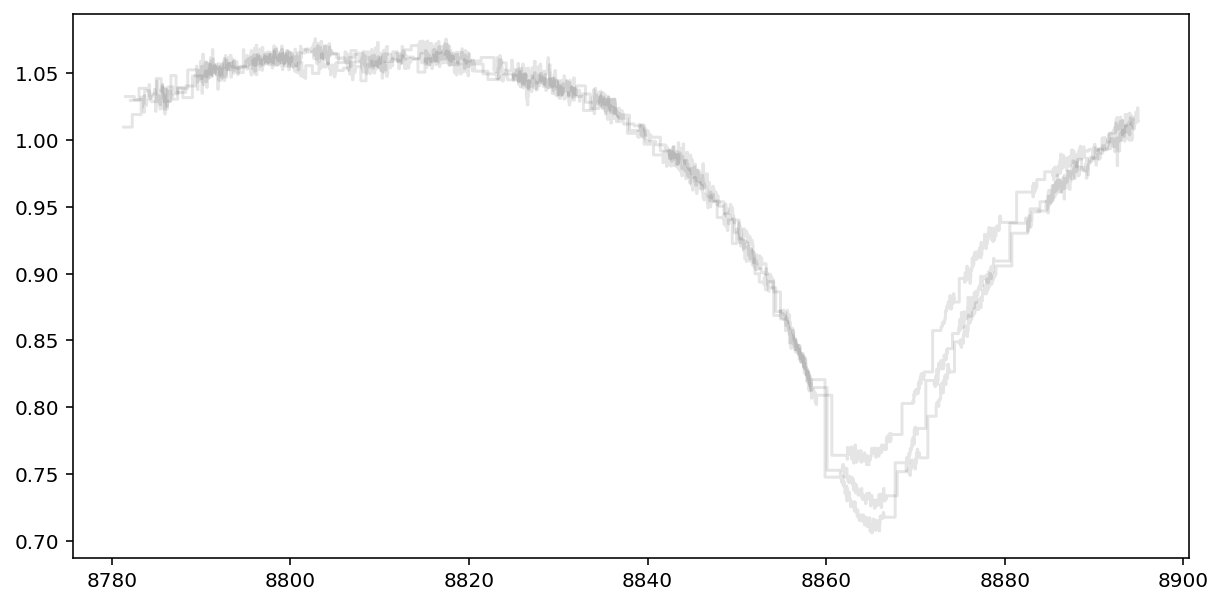

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 5))
clean_multi_spec = []
for i in range(n_spectra):
    clean_spectrum = multi_spectra[i].deblaze()\
        .trim_edges((4, 2042))\
        .normalize()\
        .mask_tellurics()\
        .barycentric_correct()
    clean_spectrum.plot(ax, color='k',alpha=0.1) #plot singular spectra
    clean_multi_spec.append(clean_spectrum) #save all clean spectra in list

These three spectra come from different objects, so they're not the best example, but they are misaligned, which is the central theme we are trying to illustrate.  Let's use a new `muler` combine method on these spectra just to see how it works.  

In [8]:
from muler.utilities import combine_spectra_misaligned

In [9]:
combined_spec = combine_spectra_misaligned(clean_multi_spec)

In [10]:
clean_spectrum.shape, combined_spec.shape

((1259,), (2026,))

The combined spectrum may have a different shape than the typical input spectrum.  We recommend explicitly providing where you'd like the combined spectrum to be computed.  This step is optional, but it can be convenient if you have a certain wavelength grid you want to preserve.

In [11]:
pixel_midpoints = multi_spectra[0].wavelength.value

The uncertainty is determined by computing the sample standard deviation of the mean.

In [12]:
combined_spec_sampled_unc = combine_spectra_misaligned(clean_multi_spec, 
                                           pixel_midpoints=pixel_midpoints)

The combined spectrum will have the same shape as the pixel midpoints you pass in.

In [13]:
pixel_midpoints.shape, combined_spec_sampled_unc.shape

((2048,), (2048,))

You can optionally request to propagate the uncertainties, if your spectra have them:

In [14]:
combined_spec_propagated_unc = combine_spectra_misaligned(clean_multi_spec, 
                                           pixel_midpoints=pixel_midpoints, 
                                           propagate_uncertainty=True)

You can also ask for `propagate_uncertainty='max'` which returns whatever uncertainty is *higher*.

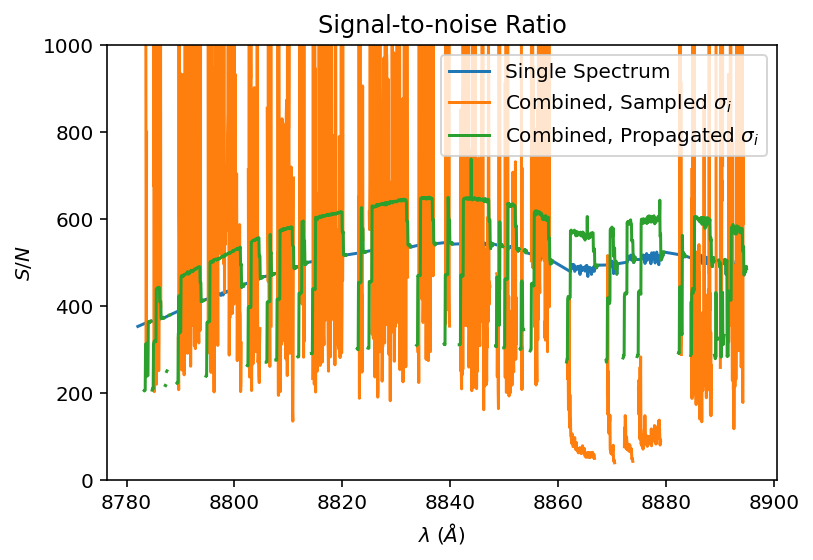

In [15]:
plt.plot(clean_spectrum.wavelength, clean_spectrum.snr, label='Single Spectrum')
plt.plot(combined_spec_sampled_unc.wavelength, combined_spec_sampled_unc.snr, label='Combined, Sampled $\sigma_i$')
plt.plot(combined_spec_propagated_unc.wavelength, combined_spec_propagated_unc.snr, label='Combined, Propagated $\sigma_i$')
plt.ylim(0, 1000)
plt.ylabel('$S/N$')
plt.xlabel('$\lambda \;(\AA)$')
plt.title('Signal-to-noise Ratio')
plt.legend();

All of the usual metadata keywords are preserved:

In [16]:
combined_spec.instrumental_resolution

55000.0

In [17]:
combined_spec.provenance

'Target fiber'

In [18]:
combined_spec.spectrographname

'HPF'

In [19]:
combined_spec.site_name

'mcdonald'

But watch out since some metadata such as date or target name may be ill-defined for a combined spectrum, or simply not implemented yet.

In [20]:
combined_spec.astropy_time.isot, clean_spectrum.astropy_time.isot

('2021-02-12T07:29:05.149', '2021-08-01T08:36:46.579')

For example, data acquired on different times and different nights will need a user-defined way to assign a notion of "time".  We do not attempt to assign these times.  We also do not yet support accessing the `.sky` reference fiber for `HPF`.  Please file a GitHub Issue if you are interested in support for these features.  

This method is probably not suitable for precision radial velocity applications, and in general many applications may wish to preserve the native sampling of their spectra during inference procedures.